This script was made based on Tensorflow's tutorial: https://www.tensorflow.org/tutorials/load_data/images

In [0]:
# imports

from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

tf.enable_eager_execution()  

AUTOTUNE = tf.data.experimental.AUTOTUNE  # decidir o número de núcleos do processador a ser utilizado
EPOCHS = 500
IMG_W = 96
IMG_H = 96
TRAIN_TEST_RATIO = 0.8

In [0]:
data_root = pathlib.Path('quadros')
all_image_paths = list(data_root.glob('*/*.jpg'))

In [0]:
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)

In [0]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_to_index = dict((name, index) for index,name in enumerate(label_names))
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]

In [0]:
#pre-processamento

def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)  #  carrega as imagens pra memória
  image = tf.image.resize(image, [IMG_W, IMG_H])  #  redimensiona elas
  image = tf.image.rgb_to_grayscale(image)  #  trás pra escala de cinza [W x H x 3] -> [W x H]
  image = tf.reshape(image, (9216,))  #  transforma em um vetor
  image /= 255.0 # normaliza para o intervalo [0,1]
  return image

def load_and_preprocess_image(path):
  image = tf.read_file(path)
  return preprocess_image(image)

In [0]:
#tensorflow dataset

path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))


In [0]:
#preparando o dataset para ser treinado

BATCH_SIZE = int(image_count * TRAIN_TEST_RATIO)  #para treinar o dataset completo em todas as epocas

test_dataset = image_label_ds.skip(image_count - BATCH_SIZE) 
train_dataset = image_label_ds.take(BATCH_SIZE)

ds = train_dataset.shuffle(buffer_size=BATCH_SIZE)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)

ds = ds.prefetch(buffer_size=AUTOTUNE)

tds = test_dataset.shuffle(buffer_size=image_count-BATCH_SIZE)
tds = tds.repeat()
tds = tds.batch(image_count - BATCH_SIZE)
tds = tds.prefetch(buffer_size=AUTOTUNE)


In [0]:
#Definindo o modelo da rede

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(4608, input_dim=9216, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(2304, activation='tanh'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(19, activation='softmax'))


In [0]:
model.compile(
    optimizer = 'SGD', 
    loss = tf.keras.losses.sparse_categorical_crossentropy,
    metrics = ["accuracy"]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4608)              42471936  
_________________________________________________________________
dropout_2 (Dropout)          (None, 4608)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2304)              10619136  
_________________________________________________________________
dropout_3 (Dropout)          (None, 2304)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 19)                43795     
Total params: 53,134,867
Trainable params: 53,134,867
Non-trainable params: 0
_________________________________________________________________


In [0]:
#treinando o modelo
H = model.fit(
    ds,  #dataset
    epochs=EPOCHS,  
    steps_per_epoch=int(len(all_image_paths)/BATCH_SIZE),  
)

Epoch 1/500
1/1 [==============================] - 1s 1s/step - loss: 0.9940 - acc: 0.8254
Epoch 2/500
1/1 [==============================] - 1s 922ms/step - loss: 0.9883 - acc: 0.8270
Epoch 3/500
1/1 [==============================] - 1s 914ms/step - loss: 0.9944 - acc: 0.8418
Epoch 4/500
1/1 [==============================] - 1s 916ms/step - loss: 0.9688 - acc: 0.8402
Epoch 5/500
1/1 [==============================] - 1s 911ms/step - loss: 0.9865 - acc: 0.8369
Epoch 6/500
1/1 [==============================] - 1s 917ms/step - loss: 0.9675 - acc: 0.8369
Epoch 7/500
1/1 [==============================] - 1s 918ms/step - loss: 0.9913 - acc: 0.8320
Epoch 8/500
1/1 [==============================] - 1s 914ms/step - loss: 0.9848 - acc: 0.8303
Epoch 9/500
1/1 [==============================] - 1s 920ms/step - loss: 0.9766 - acc: 0.8303
Epoch 10/500
1/1 [==============================] - 1s 914ms/step - loss: 0.9953 - acc: 0.8254
Epoch 11/500
1/1 [==============================] - 1s 916ms/s

Epoch 88/500
1/1 [==============================] - 1s 921ms/step - loss: 0.8396 - acc: 0.8699
Epoch 89/500
1/1 [==============================] - 1s 925ms/step - loss: 0.8509 - acc: 0.8633
Epoch 90/500
1/1 [==============================] - 1s 921ms/step - loss: 0.8424 - acc: 0.8649
Epoch 91/500
1/1 [==============================] - 1s 917ms/step - loss: 0.8540 - acc: 0.8682
Epoch 92/500
1/1 [==============================] - 1s 924ms/step - loss: 0.8350 - acc: 0.8649
Epoch 93/500
1/1 [==============================] - 1s 929ms/step - loss: 0.8610 - acc: 0.8699
Epoch 94/500
1/1 [==============================] - 1s 919ms/step - loss: 0.8453 - acc: 0.8418
Epoch 95/500
1/1 [==============================] - 1s 920ms/step - loss: 0.8390 - acc: 0.8550
Epoch 96/500
1/1 [==============================] - 1s 919ms/step - loss: 0.8528 - acc: 0.8649
Epoch 97/500
1/1 [==============================] - 1s 920ms/step - loss: 0.8306 - acc: 0.8649
Epoch 98/500
1/1 [==============================] 

Epoch 174/500
1/1 [==============================] - 1s 919ms/step - loss: 0.7421 - acc: 0.8814
Epoch 175/500
1/1 [==============================] - 1s 912ms/step - loss: 0.7204 - acc: 0.8913
Epoch 176/500
1/1 [==============================] - 1s 913ms/step - loss: 0.7137 - acc: 0.8946
Epoch 177/500
1/1 [==============================] - 1s 941ms/step - loss: 0.7229 - acc: 0.8995
Epoch 178/500
1/1 [==============================] - 1s 918ms/step - loss: 0.6971 - acc: 0.9094
Epoch 179/500
1/1 [==============================] - 1s 923ms/step - loss: 0.7249 - acc: 0.8896
Epoch 180/500
1/1 [==============================] - 1s 915ms/step - loss: 0.7069 - acc: 0.9110
Epoch 181/500
1/1 [==============================] - 1s 916ms/step - loss: 0.6978 - acc: 0.9061
Epoch 182/500
1/1 [==============================] - 1s 912ms/step - loss: 0.7084 - acc: 0.8995
Epoch 183/500
1/1 [==============================] - 1s 931ms/step - loss: 0.7278 - acc: 0.8913
Epoch 184/500
1/1 [=====================

Epoch 260/500
1/1 [==============================] - 1s 920ms/step - loss: 0.6393 - acc: 0.9028
Epoch 261/500
1/1 [==============================] - 1s 976ms/step - loss: 0.6307 - acc: 0.9044
Epoch 262/500
1/1 [==============================] - 1s 972ms/step - loss: 0.6223 - acc: 0.9259
Epoch 263/500
1/1 [==============================] - 1s 917ms/step - loss: 0.6147 - acc: 0.9077
Epoch 264/500
1/1 [==============================] - 1s 960ms/step - loss: 0.6074 - acc: 0.9242
Epoch 265/500
1/1 [==============================] - 1s 928ms/step - loss: 0.6093 - acc: 0.9160
Epoch 266/500
1/1 [==============================] - 1s 918ms/step - loss: 0.6130 - acc: 0.9209
Epoch 267/500
1/1 [==============================] - 1s 947ms/step - loss: 0.6175 - acc: 0.9061
Epoch 268/500
1/1 [==============================] - 1s 919ms/step - loss: 0.6220 - acc: 0.9209
Epoch 269/500
1/1 [==============================] - 1s 920ms/step - loss: 0.6028 - acc: 0.9044
Epoch 270/500
1/1 [=====================

Epoch 346/500
1/1 [==============================] - 1s 975ms/step - loss: 0.4955 - acc: 0.9555
Epoch 347/500
1/1 [==============================] - 1s 922ms/step - loss: 0.5000 - acc: 0.9325
Epoch 348/500
1/1 [==============================] - 1s 940ms/step - loss: 0.5031 - acc: 0.9407
Epoch 349/500
1/1 [==============================] - 1s 914ms/step - loss: 0.5011 - acc: 0.9506
Epoch 350/500
1/1 [==============================] - 1s 912ms/step - loss: 0.4988 - acc: 0.9390
Epoch 351/500
1/1 [==============================] - 1s 916ms/step - loss: 0.4936 - acc: 0.9407
Epoch 352/500
1/1 [==============================] - 1s 917ms/step - loss: 0.4940 - acc: 0.9440
Epoch 353/500
1/1 [==============================] - 1s 915ms/step - loss: 0.4908 - acc: 0.9539
Epoch 354/500
1/1 [==============================] - 1s 925ms/step - loss: 0.4906 - acc: 0.9555
Epoch 355/500
1/1 [==============================] - 1s 922ms/step - loss: 0.4953 - acc: 0.9473
Epoch 356/500
1/1 [=====================

Epoch 432/500
1/1 [==============================] - 1s 913ms/step - loss: 0.4321 - acc: 0.9588
Epoch 433/500
1/1 [==============================] - 1s 957ms/step - loss: 0.4266 - acc: 0.9588
Epoch 434/500
1/1 [==============================] - 1s 910ms/step - loss: 0.4236 - acc: 0.9539
Epoch 435/500
1/1 [==============================] - 1s 948ms/step - loss: 0.4224 - acc: 0.9588
Epoch 436/500
1/1 [==============================] - 1s 918ms/step - loss: 0.4208 - acc: 0.9654
Epoch 437/500
1/1 [==============================] - 1s 916ms/step - loss: 0.4186 - acc: 0.9671
Epoch 438/500
1/1 [==============================] - 1s 912ms/step - loss: 0.4145 - acc: 0.9687
Epoch 439/500
1/1 [==============================] - 1s 913ms/step - loss: 0.4219 - acc: 0.9638
Epoch 440/500
1/1 [==============================] - 1s 914ms/step - loss: 0.4228 - acc: 0.9687
Epoch 441/500
1/1 [==============================] - 1s 915ms/step - loss: 0.4123 - acc: 0.9621
Epoch 442/500
1/1 [=====================

In [0]:
score = model.evaluate(tds, verbose=1, steps=int(image_count - BATCH_SIZE))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

152/152 [==============================] - 23s 149ms/step - loss: 1.0610 - acc: 0.7779
Test loss: 1.0610211603343487
Test accuracy: 0.77791727


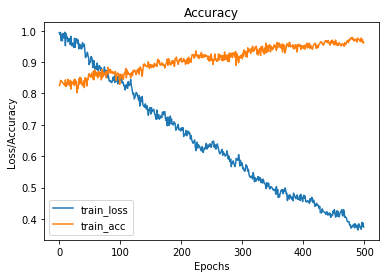

In [0]:
#Plotando no grafico

plt.figure()
plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), H.history["acc"], label="train_acc")
# plt.plot(np.arange(0, EPOCHS), H.history["val_acc"], label="val_acc")
# plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="val_loss")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()